## 資料載入與前處理（結合 review + offering 資料）
- 過濾掉 hotel_class 為空值的資料
- 合併資料集

In [3]:


import pandas as pd
import ast
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

review = pd.read_csv("./raw_data/reviews.csv")
offering = pd.read_csv("./raw_data/offerings.csv")
offering = offering[offering['hotel_class'].notna()]
merged = review.merge(offering, left_on='offering_id', right_on='id', suffixes=('_review', '_offering'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 清理資料
- 擷取整體分數 overall 作為情感標籤來源
- 建立預測星等任務的資料欄位
- 詞幹正規化 & 停用字 & 小寫

In [4]:
def extract_overall(r):
    try:
        return ast.literal_eval(r).get('overall', None)
    except:
        return None

merged['overall_rating'] = merged['ratings'].apply(extract_overall)


merged['text'] = merged['text'].astype(str)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z ]', ' ', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

merged['clean_text'] = merged['text'].apply(preprocess)


## 根據評論預測飯店星等（hotel_class）
- 建立模型根據顧客評論預測旅館的星等評級（1.0 ~ 5.0，間隔 0.5）


===== Hotel Class Prediction with Logistic Regression =====
              precision    recall  f1-score   support

         1.0       0.12      0.11      0.11      1690
         1.5       0.16      0.08      0.11      4662
         2.0       0.38      0.24      0.30     62547
         2.5       0.24      0.14      0.17     69926
         3.0       0.35      0.32      0.33    173205
         3.5       0.25      0.19      0.22    167315
         4.0       0.45      0.71      0.55    288492
         4.5       0.25      0.03      0.06     46595
         5.0       0.44      0.22      0.29     29192

    accuracy                           0.38    843624
   macro avg       0.29      0.23      0.24    843624
weighted avg       0.35      0.38      0.35    843624



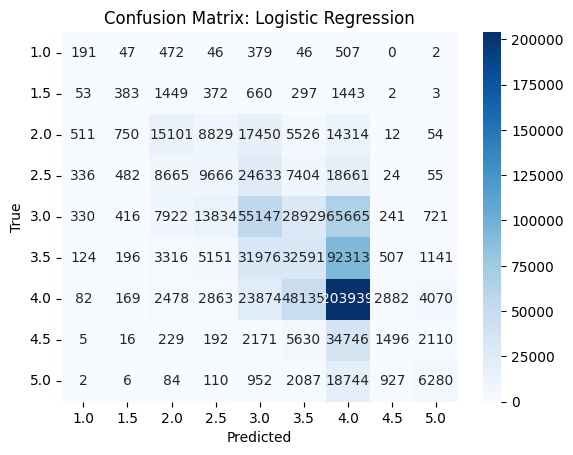

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 準備資料
X = merged['clean_text']
y = merged['hotel_class'].astype(str)

# 建立向量器與模型
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
]

# 封裝訓練與評估函式
results = {}
for name, clf in models:
    print(f"\n===== Hotel Class Prediction with {name} =====")
    vec_X = vectorizer.fit_transform(X)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    print(classification_report(y, y_pred))

    cm = confusion_matrix(y, y_pred, labels=sorted(y.unique()))
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
    ax.set_title(f"Confusion Matrix: {name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    plt.yticks(rotation=0)
    plt.show()

    results[name] = classification_report(y, y_pred, output_dict=True)

## 模型用於實際預測

In [6]:
clf_final = LogisticRegression(max_iter=1000)
vec_X = vectorizer.fit_transform(X)  # 使用整個語料建構向量器
clf_final.fit(vec_X, y)

# ➤ 測試一段新評論
def predict_star_rating(text):
    clean = preprocess(text)
    vectorized = vectorizer.transform([clean])
    prediction = clf_final.predict(vectorized)[0]
    return prediction

# ➤ 使用範例
test_review = "The room was spacious, the service was great, and location was perfect."
predicted_class = predict_star_rating(test_review)
print(f"這則評論預測的飯店星等為: {predicted_class}")

這則評論預測的飯店星等為: 4.0
